# Capstone Module 20.1 — Initial Report & EDA (Network Intrusion Detection)

## Project Summary (Non-Technical)
This project explores whether network flow features can be used to detect malicious traffic (attacks) versus normal traffic (benign). Early detection of attacks can help security teams respond faster and reduce risk.

## Business Problem
Modern networks generate large volumes of traffic. Manual monitoring cannot reliably detect attacks at scale. Machine learning can help classify traffic flows as benign or malicious to improve incident response and reduce security breaches.

## Research Question
Can flow-based network features (e.g., packet counts, byte rates, timing metrics, flags) be used to classify network traffic as BENIGN or ATTACK?

## Dataset
The dataset consists of multiple CSV files (e.g., Friday/Thursday/Wednesday PCAP flow files) with network-flow level features and a target column:
- Target column: `Label`
- Example classes: BENIGN, DDoS, PortScan, WebAttack, etc.

## Data Preparation (Module 20 scope)
- Load all CSV files from Google Drive
- Standardize column names
- Handle missing values and infinite values
- Convert Label to a binary label: BENIGN (0) vs ATTACK (1)

## Exploratory Data Analysis (EDA)
- Number of records, number of features, label distribution
- Missing and infinite value checks
- Distributions for key numeric features
- Correlation heatmap for a subset of features

## Baseline Model (Module 20 requirement)
- Model: Random Forest Classifier
- Metrics: Accuracy, Precision, Recall, F1
- Rationale: Recall is important because missing an attack (false negative) is costly.

## Next Steps (later modules)
- Engineer time-based and ratio features
- Compare multiple models using cross-validation
- Hyperparameter tuning using GridSearchCV
- Model interpretation using feature importance / SHAP


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

In [7]:
DATASET_PATH = r"/content/drive/MyDrive/Berk_CapStone/dataset"
print("Loading dataset files...")

all_files = sorted(glob.glob(os.path.join(DATASET_PATH, "*.csv")))
print("Found files:", len(all_files))

if not all_files:
    raise FileNotFoundError(f"No CSV files found in {DATASET_PATH}")

def read_one_csv(path, sample_frac=None):
    df = pd.read_csv(path, encoding="cp1252", low_memory=False)
    df.columns = df.columns.str.strip()  # keep original but trimmed
    if sample_frac is not None and 0 < sample_frac < 1:
        df = df.sample(frac=sample_frac, random_state=42)
    return df

df_list = []
for f in all_files:
    print("Reading:", os.path.basename(f))
    try:
        # If Colab memory is tight, set sample_frac=0.2 (20%) temporarily
        df_list.append(read_one_csv(f, sample_frac=None))
    except Exception as e:
        print("Error:", f, e)

full_df = pd.concat(df_list, ignore_index=True)
print("Full dataset shape:", full_df.shape)
full_df.head()


Loading dataset files...
Found files: 7
Reading: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading: Friday-WorkingHours-Morning.pcap_ISCX.csv
Reading: Monday-WorkingHours.pcap_ISCX.csv
Reading: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading: Tuesday-WorkingHours.pcap_ISCX.csv
Reading: Wednesday-workingHours.pcap_ISCX.csv
Full dataset shape: (2830743, 85)


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443.0,192.168.10.5,54865.0,6.0,7/7/2017 3:30,3.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80.0,192.168.10.5,55054.0,6.0,7/7/2017 3:30,109.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80.0,192.168.10.5,55055.0,6.0,7/7/2017 3:30,52.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443.0,192.168.10.16,46236.0,6.0,7/7/2017 3:30,34.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443.0,192.168.10.5,54863.0,6.0,7/7/2017 3:30,3.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [8]:
def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
          .str.strip()
          .str.lower()
          .str.replace(" ", "_")
          .str.replace("/", "_per_", regex=False)
          .str.replace("-", "_", regex=False)
    )
    return df

df = clean_columns(full_df)
print("Example columns:", df.columns[:15].tolist())


Example columns: ['flow_id', 'source_ip', 'source_port', 'destination_ip', 'destination_port', 'protocol', 'timestamp', 'flow_duration', 'total_fwd_packets', 'total_backward_packets', 'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 'fwd_packet_length_max', 'fwd_packet_length_min', 'fwd_packet_length_mean']


In [9]:
print("Rows, Columns:", df.shape)
print("Label values:", df["label"].value_counts().head(15))
print("\nData types (top):")
print(df.dtypes.value_counts())

# Timestamp existence check
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    print("Timestamp range:", df["timestamp"].min(), "→", df["timestamp"].max())


Rows, Columns: (2830743, 85)
Label values: label
BENIGN                        1984531
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack – Brute Force         1507
Web Attack – XSS                  652
Web Attack – Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

Data types (top):
float64    80
object      5
Name: count, dtype: int64
Timestamp range: 2017-04-07 01:00:00 → 2017-07-07 12:59:00


In [10]:
# Replace inf/-inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Show missingness
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print("Top missing columns (%):")
print(missing_pct.head(15))

Top missing columns (%):
timestamp                      28.915377
flow_bytes_per_s               10.289242
flow_packets_per_s             10.289242
source_ip                      10.195274
source_port                    10.195274
destination_port               10.195274
destination_ip                 10.195274
flow_duration                  10.195274
protocol                       10.195274
total_backward_packets         10.195274
total_length_of_fwd_packets    10.195274
total_length_of_bwd_packets    10.195274
total_fwd_packets              10.195274
fwd_packet_length_max          10.195274
fwd_packet_length_min          10.195274
dtype: float64


In [11]:
# Drop columns with >50% missing (adjust threshold if needed)
threshold = 50
drop_cols = missing_pct[missing_pct > threshold].index.tolist()
print("Dropping cols >", threshold, "% missing:", drop_cols)

df.drop(columns=drop_cols, inplace=True)

Dropping cols > 50 % missing: []


In [12]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill remaining non-numeric NaNs with "unknown"
cat_cols = [c for c in df.columns if c not in num_cols]
df[cat_cols] = df[cat_cols].fillna("unknown")

print("Missing after fix:", df.isna().sum().sum())

Missing after fix: 0


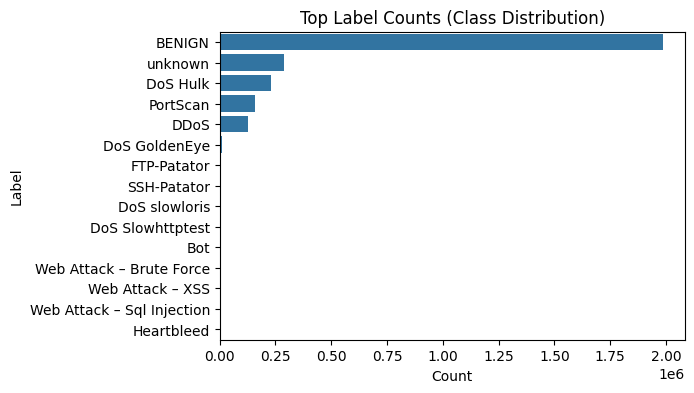

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(y="label", data=df, order=df["label"].value_counts().index[:15])
plt.title("Top Label Counts (Class Distribution)")
plt.xlabel("Count")
plt.ylabel("Label")
plt.show()

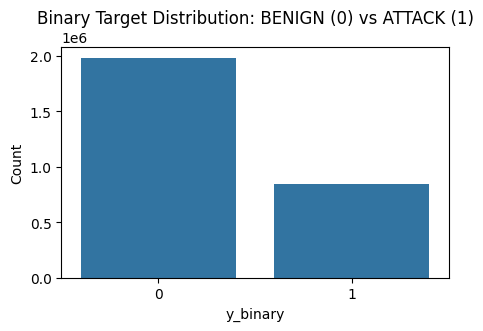

y_binary
0    0.701064
1    0.298936
Name: proportion, dtype: float64


In [14]:

df["y_binary"] = np.where(df["label"].str.upper() == "BENIGN", 0, 1)

plt.figure(figsize=(5,3))
sns.countplot(x="y_binary", data=df)
plt.title("Binary Target Distribution: BENIGN (0) vs ATTACK (1)")
plt.xlabel("y_binary")
plt.ylabel("Count")
plt.show()

print(df["y_binary"].value_counts(normalize=True))

In [15]:
missing_pct = (df.isna().mean() * 100)
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False).head(20)

if len(missing_pct) == 0:
    print("No missing values detected after cleaning.")
else:
    plt.figure(figsize=(6,4))
    missing_pct.sort_values().plot(kind="barh")
    plt.title("Top Features with Missing Values (%)")
    plt.xlabel("Percent Missing")
    plt.show()

No missing values detected after cleaning.


Plotting: ['flow_duration', 'total_fwd_packets', 'total_backward_packets', 'flow_bytes_per_s', 'flow_packets_per_s', 'packet_length_mean', 'packet_length_std', 'syn_flag_count', 'ack_flag_count']


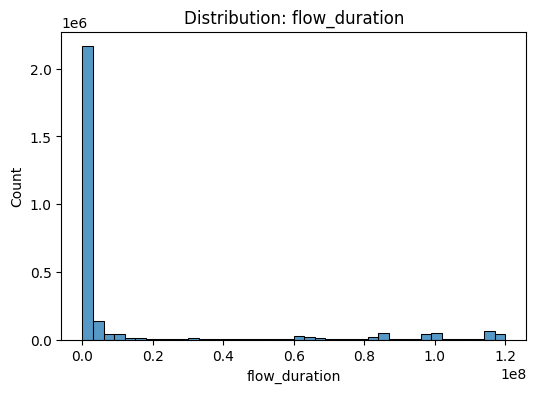

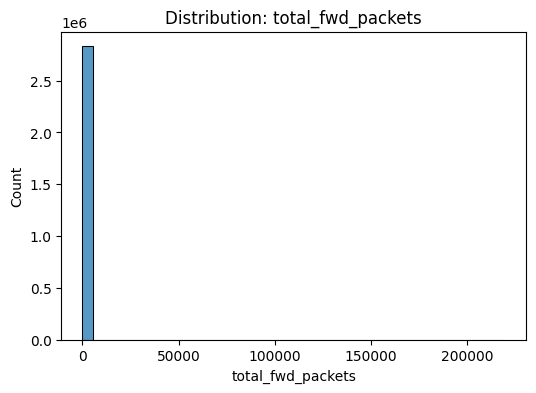

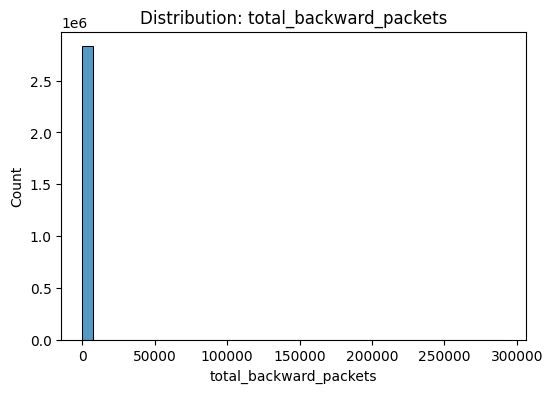

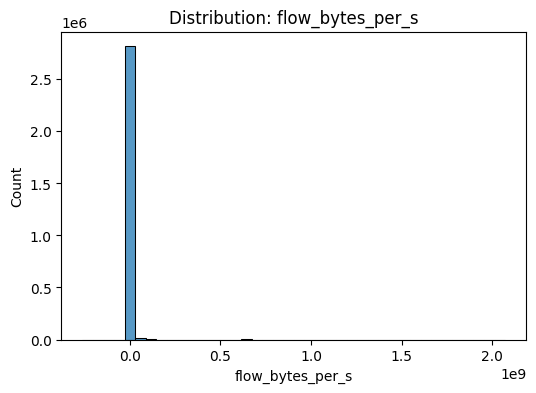

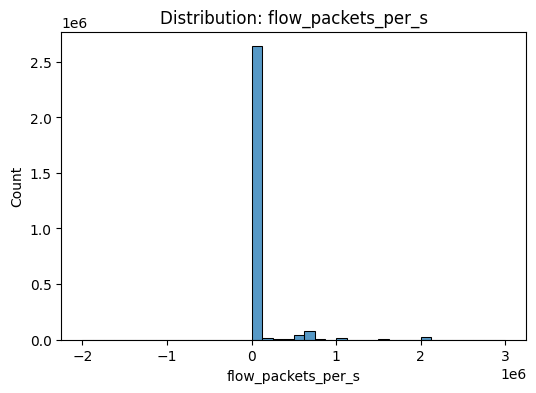

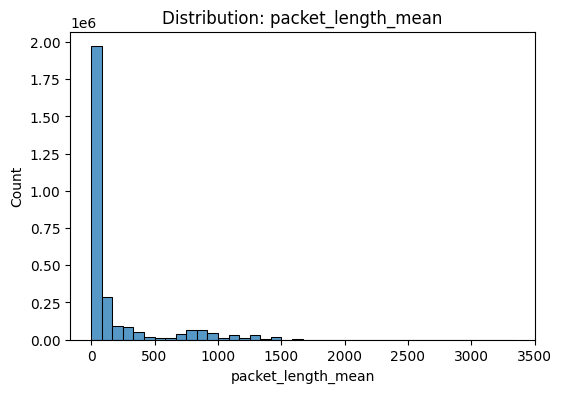

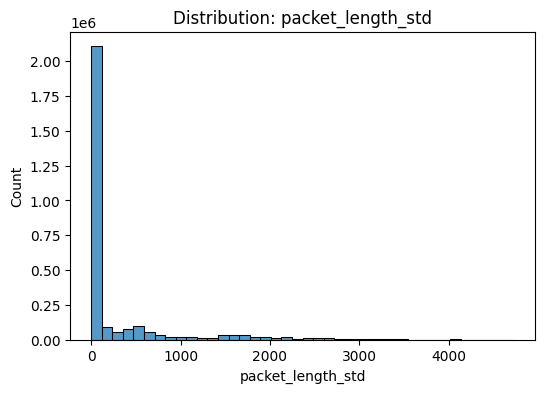

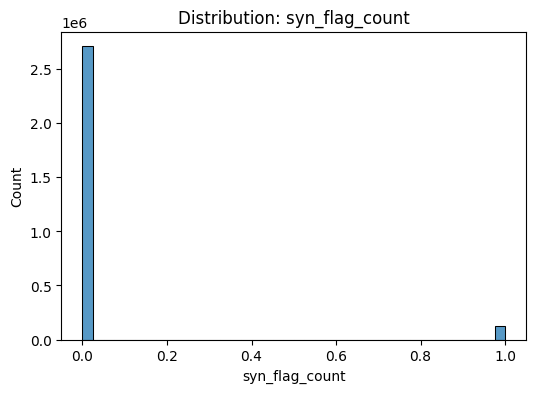

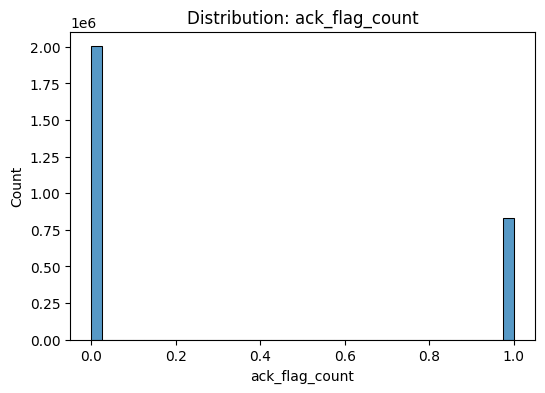

In [16]:
candidate = [c for c in [
    "flow_duration",
    "total_fwd_packets",
    "total_backward_packets",
    "flow_bytes_per_s",
    "flow_packets_per_s",
    "packet_length_mean",
    "packet_length_std",
    "syn_flag_count",
    "ack_flag_count"
] if c in df.columns]

print("Plotting:", candidate)

for c in candidate:
    plt.figure(figsize=(6,4))
    sns.histplot(df[c], bins=40)
    plt.title(f"Distribution: {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()

In [17]:
df["label"] = df["label"].astype(str).str.strip()

min_samples = 5000
counts = df["label"].value_counts()
keep_classes = counts[counts >= min_samples].index

df_mc = df[df["label"].isin(keep_classes)].copy()
print("Classes kept:", df_mc["label"].nunique())
display(df_mc["label"].value_counts())


N_PER_CLASS = 10000

df_mc = (
    df_mc.groupby("label", group_keys=False)
         .apply(lambda x: x.sample(min(len(x), N_PER_CLASS), random_state=42))
         .reset_index(drop=True)
)

print("After cap:", df_mc.shape)
display(df_mc["label"].value_counts())


Classes kept: 10


,count
label,
BENIGN,1984531
unknown,288602
DoS Hulk,231073
PortScan,158930
DDoS,128027
DoS GoldenEye,10293
FTP-Patator,7938
SSH-Patator,5897
DoS slowloris,5796


/tmp/ipython-input-770253810.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), N_PER_CLASS), random_state=42))


After cap: (185423, 86)


,count
label,
BENIGN,30000
DDoS,30000
DoS Hulk,30000
PortScan,30000
unknown,30000
DoS GoldenEye,10293
FTP-Patator,7938
SSH-Patator,5897
DoS slowloris,5796


In [18]:
df_fe = df_mc.copy()

# Safe derived features (avoid divide by zero)
eps = 1e-9

if "total_fwd_packets" in df_fe.columns and "total_backward_packets" in df_fe.columns:
    df_fe["fwd_bwd_pkt_ratio"] = df_fe["total_fwd_packets"] / (df_fe["total_backward_packets"] + eps)

if "total_length_of_fwd_packets" in df_fe.columns and "total_length_of_bwd_packets" in df_fe.columns:
    df_fe["fwd_bwd_bytes_ratio"] = df_fe["total_length_of_fwd_packets"] / (df_fe["total_length_of_bwd_packets"] + eps)

if "flow_packets_per_s" in df_fe.columns and "flow_bytes_per_s" in df_fe.columns:
    df_fe["bytes_per_packet_est"] = df_fe["flow_bytes_per_s"] / (df_fe["flow_packets_per_s"] + eps)

# Log transform for heavy-tailed features (common in network flow)
for col in ["flow_duration", "flow_bytes_per_s", "flow_packets_per_s"]:
    if col in df_fe.columns:
        df_fe[f"log1p_{col}"] = np.log1p(df_fe[col].clip(lower=0))


In [19]:
drop_cols = ["flow_id", "source_ip", "destination_ip", "timestamp", "label"]
X = df_fe.drop(columns=[c for c in drop_cols if c in df_fe.columns], errors="ignore")

# Keep numeric features only (stable for all models)
X = X.select_dtypes(include=[np.number])

y = df_fe["label"]

print("X shape:", X.shape, "| classes:", y.nunique())


X shape: (185423, 87) | classes: 10


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [21]:
numeric_features = X.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features)
    ],
    remainder="drop"
)


In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1)
}

cv_rows = []

for name, clf in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", clf)])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1_weighted")
    cv_rows.append({"Model": name, "CV F1 (weighted) mean": scores.mean(), "CV F1 (weighted) std": scores.std()})

cv_df = pd.DataFrame(cv_rows).sort_values("CV F1 (weighted) mean", ascending=False)
cv_df


,Model,CV F1 (weighted) mean,CV F1 (weighted) std
0,Decision Tree,0.999525,0.000110
2,Random Forest,0.999389,0.000109
1,Logistic Regression,0.998053,0.000323


In [ ]:
# Decision Tree depth sensitivity check
dt_depths = [5, 10, 20, None]
dt_scores = []

for d in dt_depths:
    dt = DecisionTreeClassifier(
        max_depth=d,
        random_state=42
    )
    pipe = Pipeline([
        ("preprocess", preprocess_tree),
        ("model", dt)
    ])
    score = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring="f1_weighted"
    ).mean()
    dt_scores.append(score)

dt_depth_df = pd.DataFrame({
    "max_depth": dt_depths,
    "CV F1 (weighted)": dt_scores
})

dt_depth_df


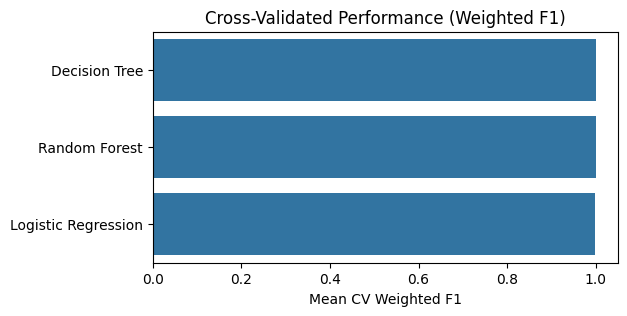

In [23]:
plt.figure(figsize=(6,3))
sns.barplot(data=cv_df, x="CV F1 (weighted) mean", y="Model")
plt.title("Cross-Validated Performance (Weighted F1)")
plt.xlabel("Mean CV Weighted F1")
plt.ylabel("")
plt.show()


In [24]:
dt_pipe = Pipeline(steps=[("preprocess", preprocess),
                         ("model", DecisionTreeClassifier(random_state=42))])

dt_grid = {
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 10, 20],
    "model__min_samples_leaf": [1, 5, 10]
}

dt_search = GridSearchCV(dt_pipe, dt_grid, cv=cv, scoring="f1_weighted", n_jobs=-1)
dt_search.fit(X_train, y_train)
dt_search.best_params_, dt_search.best_score_


({'model__max_depth': None,
  'model__min_samples_leaf': 1,
  'model__min_samples_split': 2},
 np.float64(0.999525376714945))

In [25]:
lr_pipe = Pipeline(steps=[("preprocess", preprocess),
                         ("model", LogisticRegression(max_iter=3000, n_jobs=-1))])

lr_grid = {
    "model__C": [0.1, 1.0, 10.0],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

lr_search = GridSearchCV(lr_pipe, lr_grid, cv=cv, scoring="f1_weighted", n_jobs=-1)
lr_search.fit(X_train, y_train)
lr_search.best_params_, lr_search.best_score_


({'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'},
 np.float64(0.9982681288743283))

In [26]:
rf_pipe = Pipeline(steps=[("preprocess", preprocess),
                         ("model", RandomForestClassifier(random_state=42, n_jobs=-1))])

rf_grid_fast = {
    "model__n_estimators": [150],
    "model__max_depth": [None, 20],
    "model__min_samples_split": [2, 10],
    "model__min_samples_leaf": [1, 5],
    "model__class_weight": ["balanced_subsample"]
}

rf_search = GridSearchCV(rf_pipe, rf_grid, cv=cv, scoring="f1_weighted", n_jobs=-1)
rf_search.fit(X_train, y_train)
rf_search.best_params_, rf_search.best_score_


({'model__class_weight': 'balanced_subsample',
  'model__max_depth': 20,
  'model__min_samples_leaf': 1,
  'model__min_samples_split': 10,
  'model__n_estimators': 200},
 np.float64(0.9993886766271836))

In [27]:
tuned_results = pd.DataFrame([
    {"Model": "Decision Tree (tuned)", "Best CV F1 (weighted)": dt_search.best_score_},
    {"Model": "Logistic Regression (tuned)", "Best CV F1 (weighted)": lr_search.best_score_},
    {"Model": "Random Forest (tuned)", "Best CV F1 (weighted)": rf_search.best_score_},
]).sort_values("Best CV F1 (weighted)", ascending=False)

tuned_results


,Model,Best CV F1 (weighted)
0,Decision Tree (tuned),0.999525
2,Random Forest (tuned),0.999389
1,Logistic Regression (tuned),0.998268


In [28]:
best_model = rf_search.best_estimator_  # change if another wins
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))


                  precision    recall  f1-score   support

          BENIGN     0.9993    1.0000    0.9997      7500
            DDoS     1.0000    1.0000    1.0000      7500
   DoS GoldenEye     0.9984    0.9996    0.9990      2573
        DoS Hulk     0.9989    0.9993    0.9991      7500
DoS Slowhttptest     0.9985    0.9964    0.9975      1375
   DoS slowloris     0.9972    0.9972    0.9972      1449
     FTP-Patator     1.0000    1.0000    1.0000      1985
        PortScan     1.0000    0.9989    0.9995      7500
     SSH-Patator     1.0000    1.0000    1.0000      1474
         unknown     1.0000    1.0000    1.0000      7500

        accuracy                         0.9995     46356
       macro avg     0.9992    0.9991    0.9992     46356
    weighted avg     0.9995    0.9995    0.9995     46356



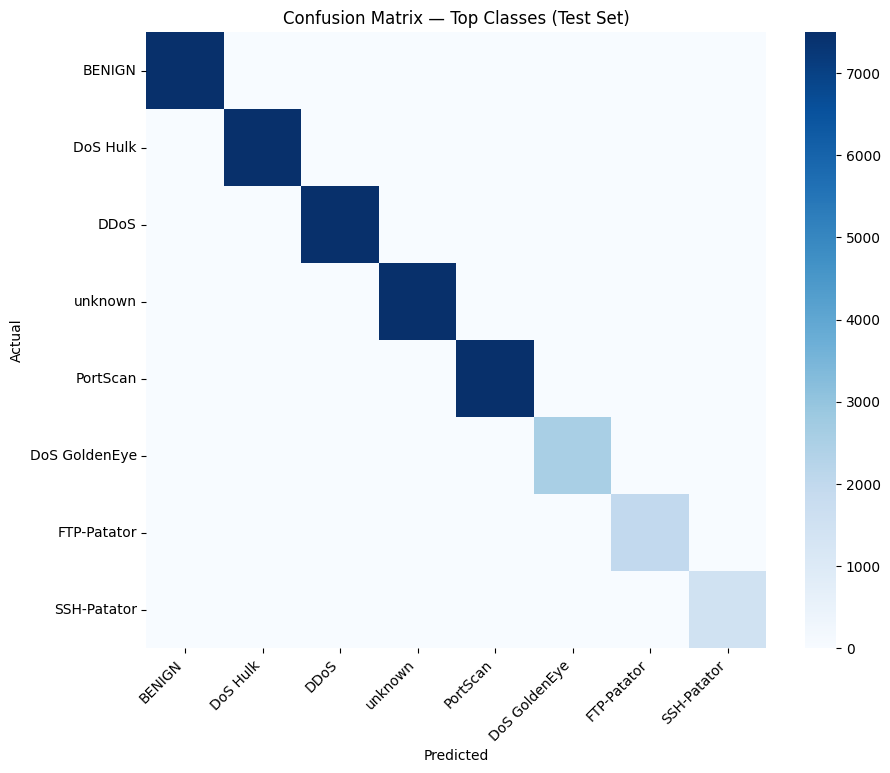

In [29]:
top_classes = y_test.value_counts().index[:8].tolist()

mask = y_test.isin(top_classes)
cm = confusion_matrix(y_test[mask], y_pred[mask], labels=top_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", xticklabels=top_classes, yticklabels=top_classes)
plt.title("Confusion Matrix — Top Classes (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


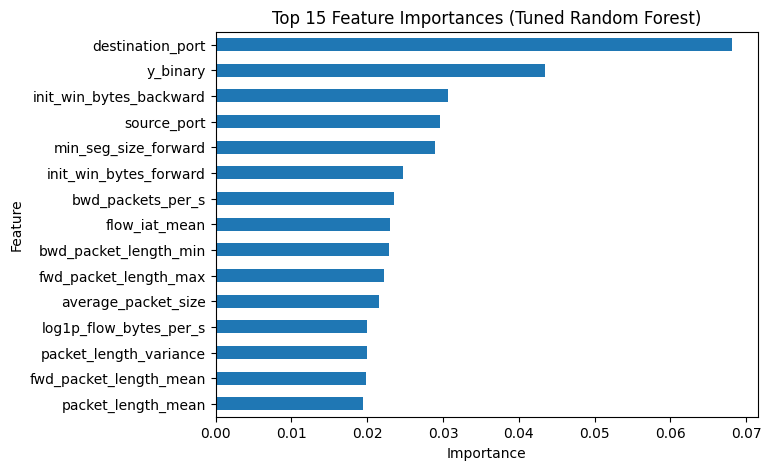

In [30]:
# Only works if best_model is RF
if hasattr(best_model.named_steps["model"], "feature_importances_"):
    importances = best_model.named_steps["model"].feature_importances_
    feat_names = X.columns
    imp = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(15)

    plt.figure(figsize=(7,5))
    imp.sort_values().plot(kind="barh")
    plt.title("Top 15 Feature Importances (Tuned Random Forest)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

    imp
